In [4]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score

# Load models and vectorizers
# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Split data into training and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    stacked_features, y_test, test_size=0.2, random_state=42, stratify=y_test
)

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    max_depth=None,            # Maximum depth of each tree
    min_samples_split=20,      # Minimum number of samples to split a node

    min_samples_leaf=1,        # Minimum number of samples in a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    bootstrap=False,            # Whether to use bootstrapping

    random_state=42            # For reproducibility
    )
meta_learner_rf.fit(X_train1, y_train1)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner
final_predictions_rf = meta_learner_rf.predict(X_test1)

# Evaluate the Random Forest ensemble model
accuracy_rf = accuracy_score(y_test1, final_predictions_rf)
report_rf = classification_report(y_test1, final_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test1, final_predictions_rf))

"""
# Calculate the mean and standard deviation of validation accuracies
cross_val_accuracies = cross_val_score(
    meta_learner_rf, stacked_features, y_test, cv=5, scoring='accuracy'
)

mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")
"""

from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform stratified cross-validation and compute accuracies
cross_val_accuracies = []
for train_index, test_index in skf.split(stacked_features, y_test):
    X_train_fold, X_test_fold = stacked_features[train_index], stacked_features[test_index]
    y_train_fold, y_test_fold = y_test[train_index], y_test[test_index]

    meta_learner_rf.fit(X_train_fold, y_train_fold)
    fold_accuracy = meta_learner_rf.score(X_test_fold, y_test_fold)
    cross_val_accuracies.append(fold_accuracy)

# Convert to NumPy array for consistency
cross_val_accuracies = np.array(cross_val_accuracies)

# Calculate mean and standard deviation
mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")


581/581 ━━━━━━━━━━━━━━━━━━━━ 55s 93ms/step
Random Forest Meta-Learner Accuracy: 97.76%
Classification Report (Random Forest):
               precision    recall  f1-score   support

     anxiety       0.98      0.97      0.98       400
     bipolar       0.96      0.90      0.93       388
  depression       0.97      0.96      0.96       392
      normal       0.98      1.00      0.99      2136
        ptsd       0.97      0.97      0.97       397

    accuracy                           0.98      3713
   macro avg       0.97      0.96      0.97      3713
weighted avg       0.98      0.98      0.98      3713

Confusion Matrix (Random Forest):
 [[ 389    2    4    2    3]
 [   1  351    4   28    4]
 [   6    4  377    1    4]
 [   0    8    0 2127    1]
 [   1    2    5    3  386]]
Cross-Validation Accuracies: [0.98195529 0.97549152 0.98060867 0.97603016 0.97629949]
Mean Validation Accuracy: 97.81%
Validation Accuracy Std Dev: 0.27%


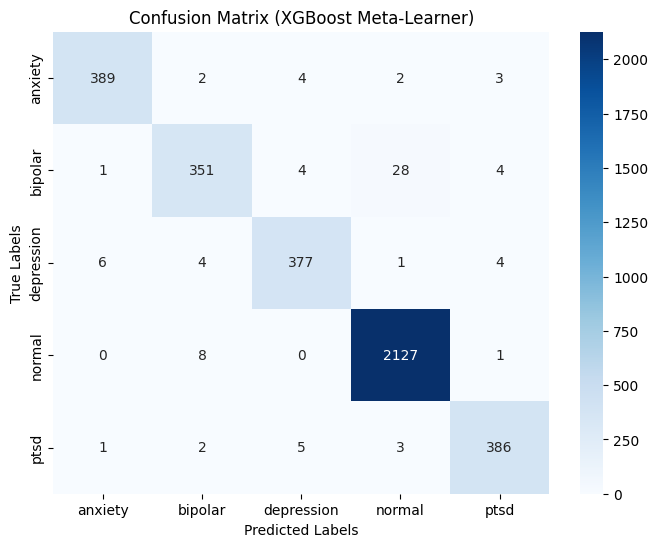

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test1, final_predictions_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (XGBoost Meta-Learner)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


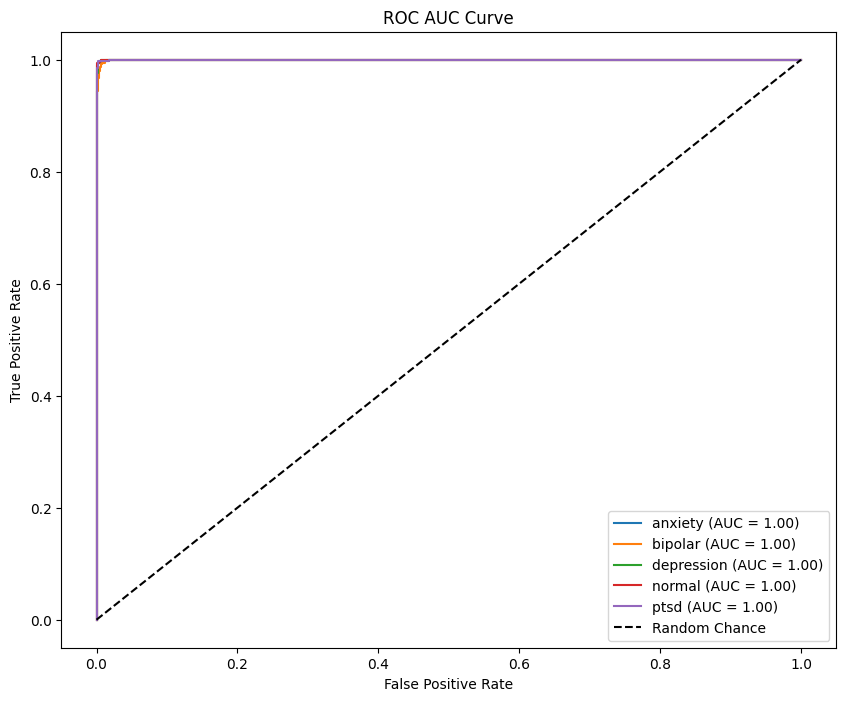

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output (one-vs-rest)
y_test_bin = label_binarize(y_test1, classes=range(len(label_encoder.classes_)))

# Calculate probabilities for the test set only
final_predictions_proba = meta_learner_rf.predict_proba(X_test1) # Changed stacked_features to X_test

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], final_predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()